In [375]:
import pandas as pd
import numpy as np
import os
import itertools
import re

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from time import strptime

In [154]:
path = r"C:\Users\Acer\Git\deda_punks" 
os.chdir(path)

In [421]:
def merge_punks_to_clusters () :
    scraped = pd.read_csv(r"all_offered_punks_.csv")
    cluster_names = pd.read_csv(r"punks cluster names.csv")

    cluster_names.rename({"Punk Name":"Punk_ID", "Cluster Group":"Cluster_ID"}, axis = 1, inplace = True)
    cluster_names.Punk_ID = list(itertools.chain(*cluster_names.Punk_ID.apply(lambda x: re.findall("(\d+)", x))))

    cluster_names.Punk_ID = cluster_names.Punk_ID.astype(int)
    cluster_names.Cluster_ID = cluster_names.Cluster_ID.astype(int)

    scraped = scraped.merge(cluster_names, on = "Punk_ID", how="left")
    scraped = scraped[scraped.Cluster_ID.isnull()==False]
    
    scraped.Cluster_ID = scraped.Cluster_ID.astype(int)
    return scraped

def get_log_price (scraped):
    scraped["log_price"] = np.log(scraped['price_in_dollars'], where=scraped['price_in_dollars']>0)  
    return scraped

def plot_boxplots (data, fig_x, fig_y, plot_name, save_plot=False):
    sns.set(rc={'figure.figsize':(fig_x, fig_y)})
    sns.boxplot(y=data["log_price"], x=data["Cluster_ID"], palette="Blues")
    if save_plot==False:
        plt.show()   
    else:
        plt.savefig(f"{plot_name}.png")

def get_mean_price_per_cluster (scraped):
    highest_avg_price = scraped.groupby(scraped["Cluster_ID"])["price_in_dollars"].mean().nlargest(5).index
    data_sample = scraped[scraped.Cluster_ID.isin(highest_avg_price)]
    return data_sample
    
def fix_date_format (scraped):
    scraped["Month_number"] = scraped.Month.apply(lambda x: strptime(x,'%b').tm_mon)
    scraped["Full-date"] = scraped.Month_number.astype(str) + "-" + scraped.Year.astype(str)
    scraped["Full-date"] = scraped["Full-date"].apply(lambda x: datetime.strptime(x, "%m-%Y"))
    return scraped

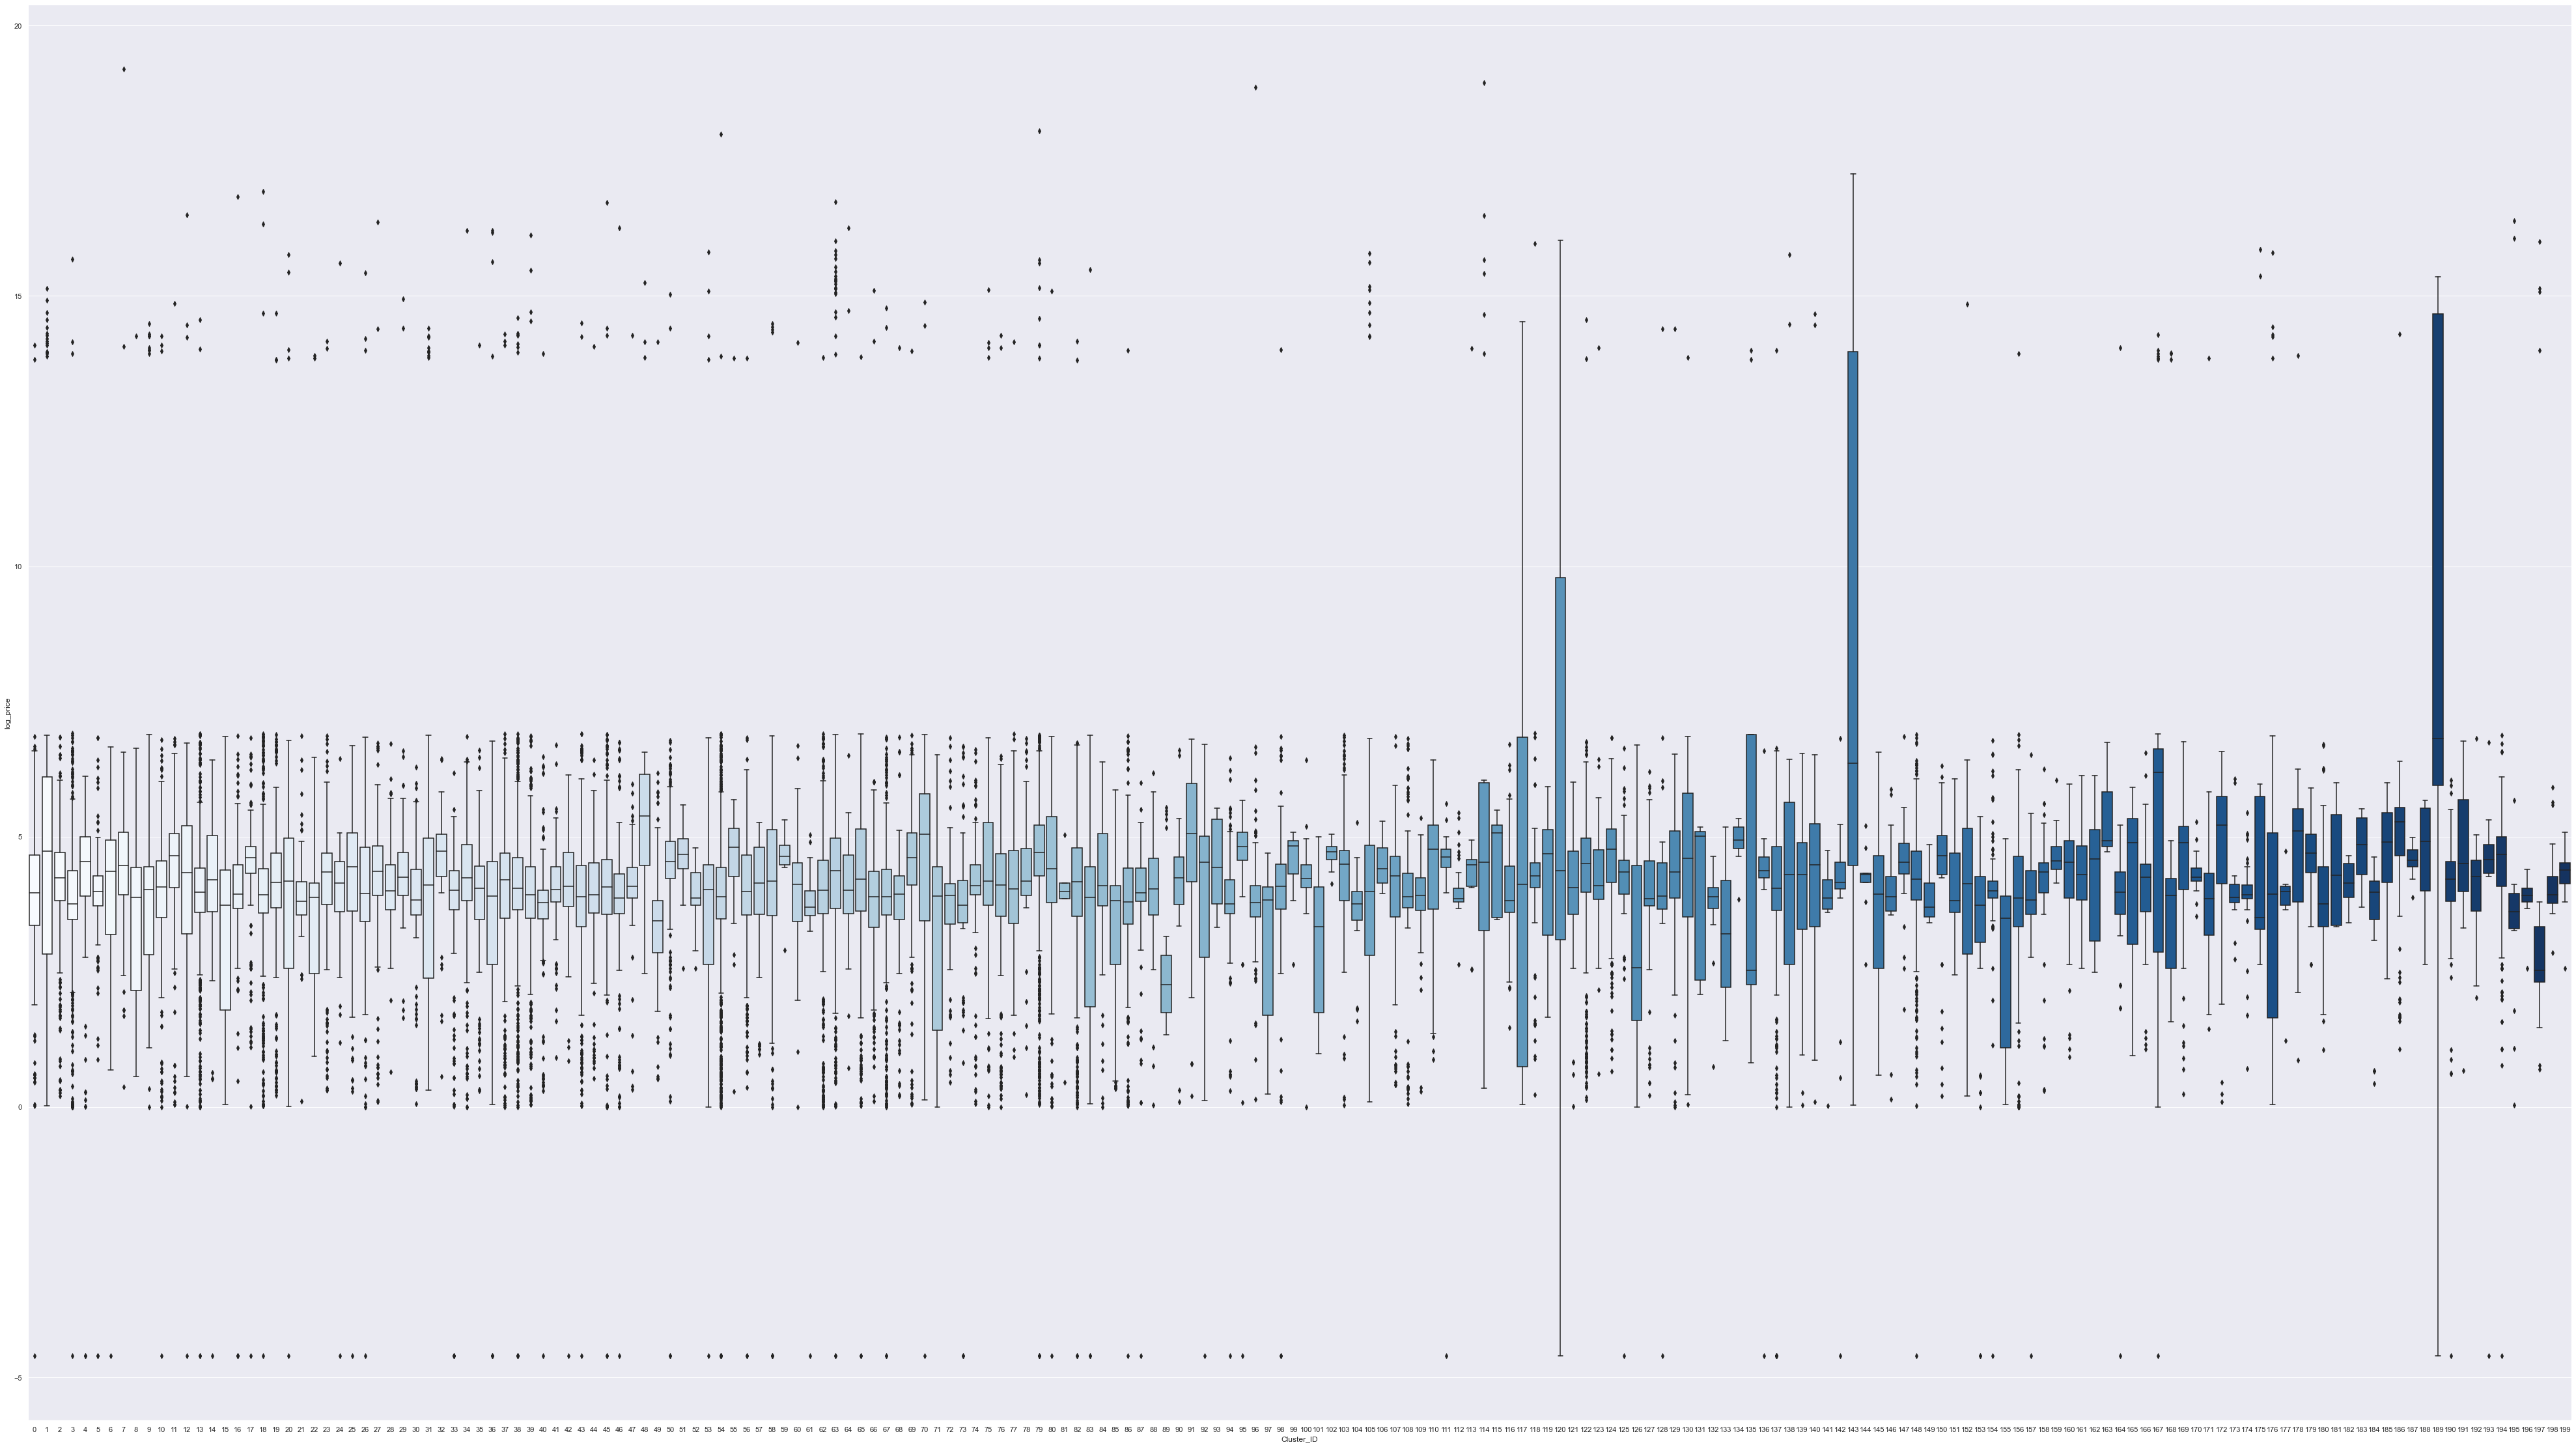

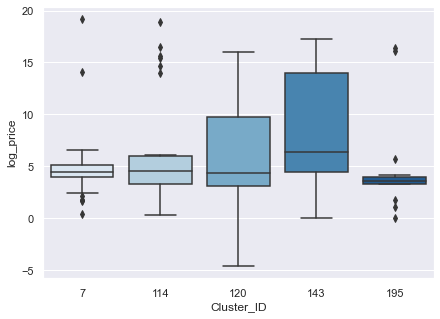

In [422]:
scraped = merge_punks_to_clusters()
scraped = get_log_price(scraped)
data_sample = get_mean_price_per_cluster(scraped)

plot_boxplots(scraped, 70, 40, "all_data", save_plot = False)
plot_boxplots(data_sample, 7, 5, "selected_data", save_plot = False)
    
scraped = fix_date_format(scraped)

Volatility

In [380]:
def aggregate_price_on_same_date (scraped):
    vol = scraped.groupby(["Cluster_ID", "Full-date"])["log_price"].mean().reset_index()
    vol.rename({"log_price":"mean_log_price"}, axis = 1, inplace = True)
    return vol

def calc_volatility (vol):
    vol = vol.sort_values(["Cluster_ID", "Full-date"])
    vol["t_change"] = vol.groupby("Cluster_ID")["mean_log_price"].apply(lambda x: (x/x.shift(1))-1)
    
    vol_ = vol.groupby("Cluster_ID")["t_change"].std().reset_index()
    vol_.rename({"t_change":"volatility"}, axis = 1, inplace = True)
    
    vol_ = vol_.merge(vol.groupby("Cluster_ID")["mean_log_price"].mean().reset_index(), on = "Cluster_ID", how = "left")
    return vol_

In [381]:
vol = aggregate_price_on_same_date (scraped)
vol_ = calc_volatility(vol)

In [384]:
vol_.head()

,Cluster_ID,volatility,mean_log_price
0,0.0,1.472449,3.858983
1,1.0,0.312704,4.842638
2,2.0,0.410829,4.202917
3,3.0,0.968255,3.865834
4,4.0,56.506407,3.841327


In [391]:
def volatility_within_price_range (vol_, topn=True, n=100):
    if topn==True:
        max_avg_price = vol_[vol_.mean_log_price.isin(vol_.mean_log_price.nlargest(n))]
    if topn==False:
        lower_bound, upper_bound = input("Input lower filtering bound:"), input("Input higher filtering bound:")
        max_avg_price = vol_[(vol_.mean_log_price>int(lower_bound)) & (vol_.mean_log_price<int(upper_bound))].copy()
    print(max_avg_price[(max_avg_price.volatility == max_avg_price.volatility.min())])
    return max_avg_price

In [408]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.09, point['y'], str(point['val']))

def do_scatterplot (max_avg_price_sample, save_plot=False):
    max_avg_price_sample.Cluster_ID = max_avg_price_sample.Cluster_ID.astype(int).astype(str)
    
    sns.scatterplot(data=max_avg_price_sample, x="volatility", y="mean_log_price", hue="Cluster_ID", legend=False)
    label_point(max_avg_price_sample.volatility, max_avg_price_sample.mean_log_price, max_avg_price_sample.Cluster_ID, plt.gca())
    if save_plot == True:
        plt.savefig("scatterplot.png")

In [424]:
max_avg_price = volatility_within_price_range(vol_, topn=False)

Input lower filtering bound: 0
Input higher filtering bound: 4


     Cluster_ID  volatility  mean_log_price
149       149.0    0.095086        3.849787


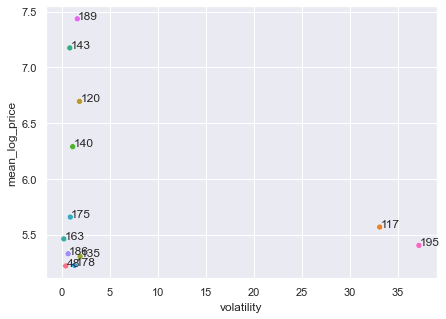

In [410]:
do_scatterplot (max_avg_price_sample, save_plot=True)

In [355]:
scraped_sample = scraped[scraped.Cluster_ID.isin([189, 120, 140, 143])]

<AxesSubplot:xlabel='Full-date', ylabel='log_price'>

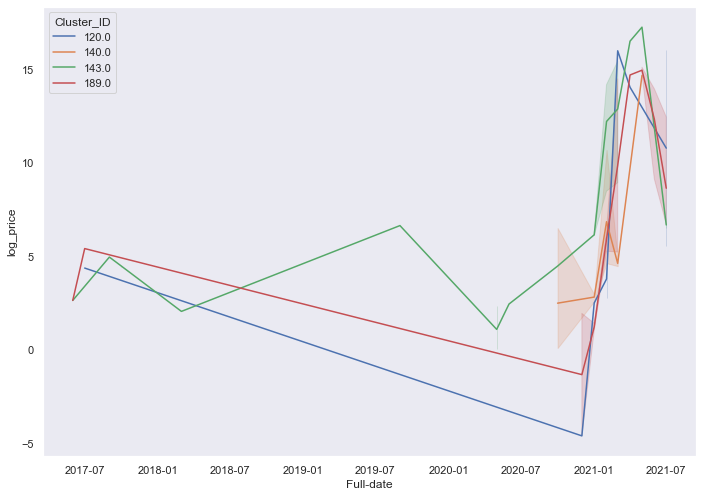

In [356]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("dark")
sns.lineplot(x="Full-date", y="log_price",
             hue="Cluster_ID", 
             data=scraped_sample, palette="deep")